In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


sns.set_style('whitegrid')


# load dataset
flights = sns.load_dataset('flights')
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [ ]:
flights = flights.assign(
date=pd.to_datetime(flights['year'].astype(str) + '-' + flights['month'].astype(str) + '-01')
).set_index('date')


flights = flights[['passengers']]
flights.index.freq = 'MS' # monthly start
flights.tail()

,passengers
date,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


Question for students: "If timestamps change or are missing, does the meaning stay the same?"


We'll show the original series, then versions with missing timestamps, irregular spacing, and duplicated timestamps.

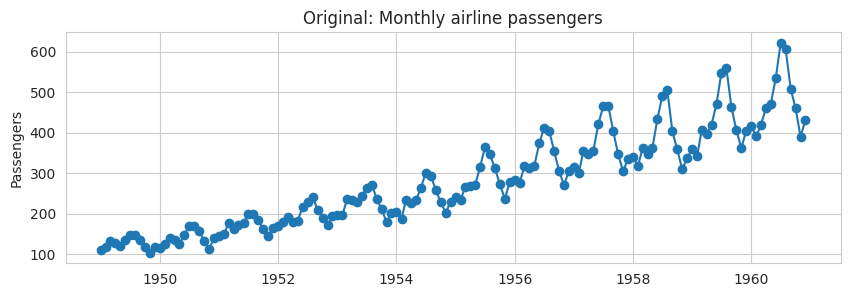

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(flights.index, flights['passengers'], marker='o')
plt.title('Original: Monthly airline passengers')
plt.ylabel('Passengers')
plt.show()

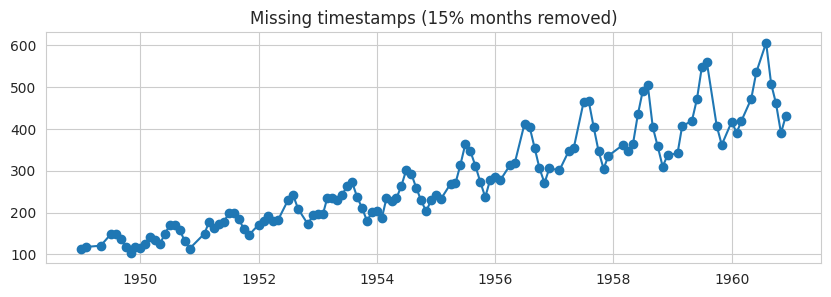

In [ ]:
missing = flights.drop(flights.sample(frac=0.15, random_state=2).index)
plt.figure(figsize=(10,3))
plt.plot(missing.index, missing['passengers'], marker='o')
plt.title('Missing timestamps (15% months removed)')
plt.show()

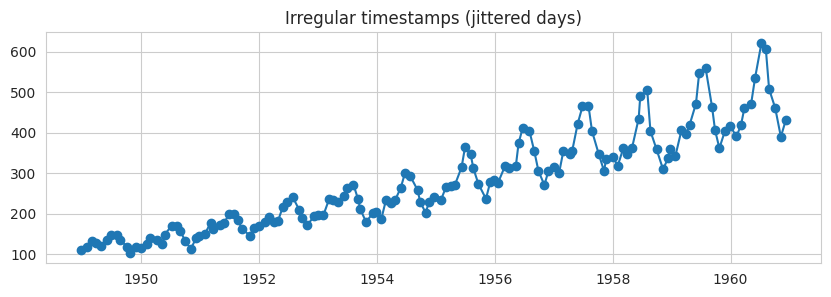

In [ ]:
irregular = flights.copy().reset_index()
import numpy as np
np.random.seed(1)
# add jitter to dates (up to +/-10 days)
irregular['date_jittered'] = irregular['date'] + pd.to_timedelta(np.random.randint(-10, 11, size=len(irregular)), unit='D')
irregular = irregular.set_index('date_jittered').sort_index()
plt.figure(figsize=(10,3))
plt.plot(irregular.index, irregular['passengers'], marker='o')
plt.title('Irregular timestamps (jittered days)')
plt.show()

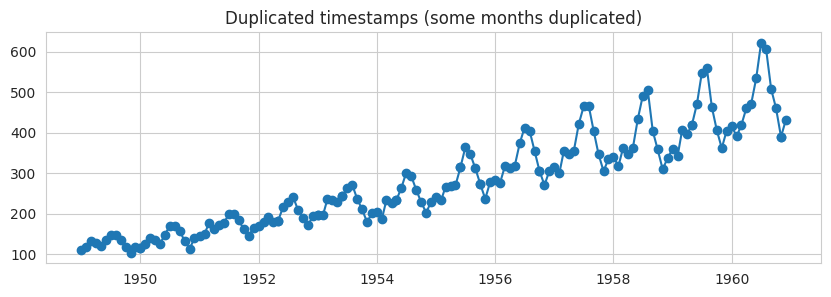

In [ ]:
# dups = flights.concat(flights.sample(10, random_state=5))
dups = pd.concat([flights, flights.sample(10, random_state=5)])
dups = dups.sort_index()
plt.figure(figsize=(10,3))
plt.plot(dups.index, dups['passengers'], marker='o')
plt.title('Duplicated timestamps (some months duplicated)')
plt.show()

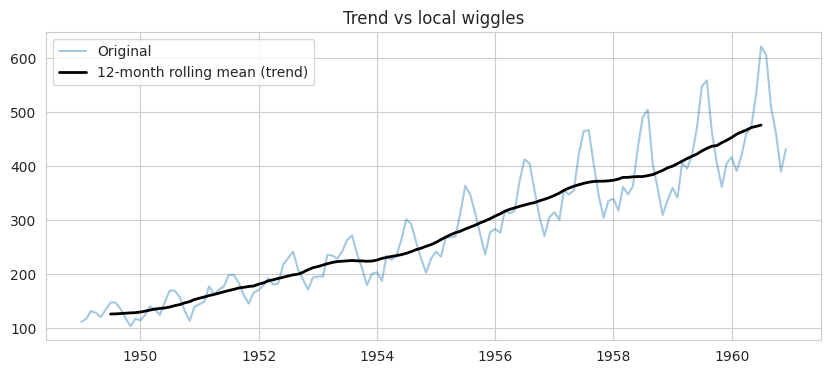

In [ ]:
flights['trend_12m'] = flights['passengers'].rolling(window=12, center=True).mean()
plt.figure(figsize=(10,4))
plt.plot(flights.index, flights['passengers'], alpha=0.4, label='Original')
plt.plot(flights.index, flights['trend_12m'], color='black', linewidth=2, label='12-month rolling mean (trend)')
plt.legend()
plt.title('Trend vs local wiggles')
plt.show()

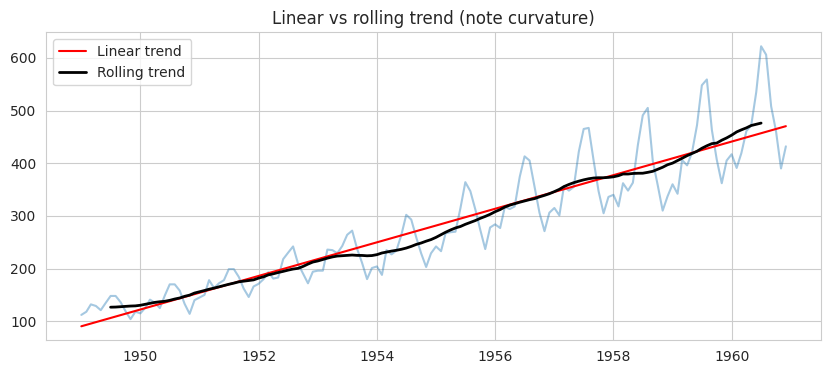

In [ ]:
from sklearn.linear_model import LinearRegression
X = (flights.index - flights.index[0]).days.values.reshape(-1,1)
y = flights['passengers'].values
lr = LinearRegression().fit(X, y)
flights['linear_trend'] = lr.predict(X)


plt.figure(figsize=(10,4))
plt.plot(flights.index, flights['passengers'], alpha=0.4)
plt.plot(flights.index, flights['linear_trend'], color='red', label='Linear trend')
plt.plot(flights.index, flights['trend_12m'], color='black', linewidth=2, label='Rolling trend')
plt.legend()
plt.title('Linear vs rolling trend (note curvature)')
plt.show()

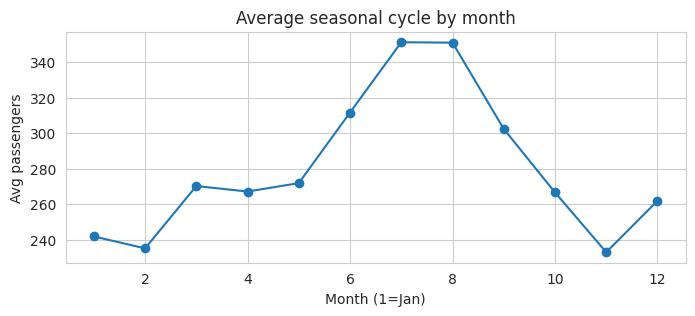

In [ ]:
monthly_mean = flights.groupby(flights.index.month)['passengers'].mean()
plt.figure(figsize=(8,3))
monthly_mean.plot(marker='o')
plt.title('Average seasonal cycle by month')
plt.xlabel('Month (1=Jan)')
plt.ylabel('Avg passengers')
plt.show()

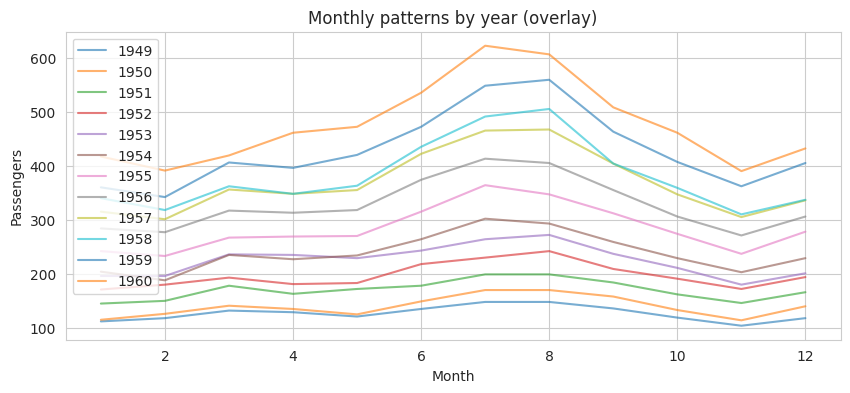

In [ ]:
plt.figure(figsize=(10,4))
for yr in sorted(set(flights.index.year)):
  series = flights[flights.index.year == yr]['passengers']
  plt.plot(series.index.month, series.values, alpha=0.6, label=str(yr))
plt.title('Monthly patterns by year (overlay)')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.show()

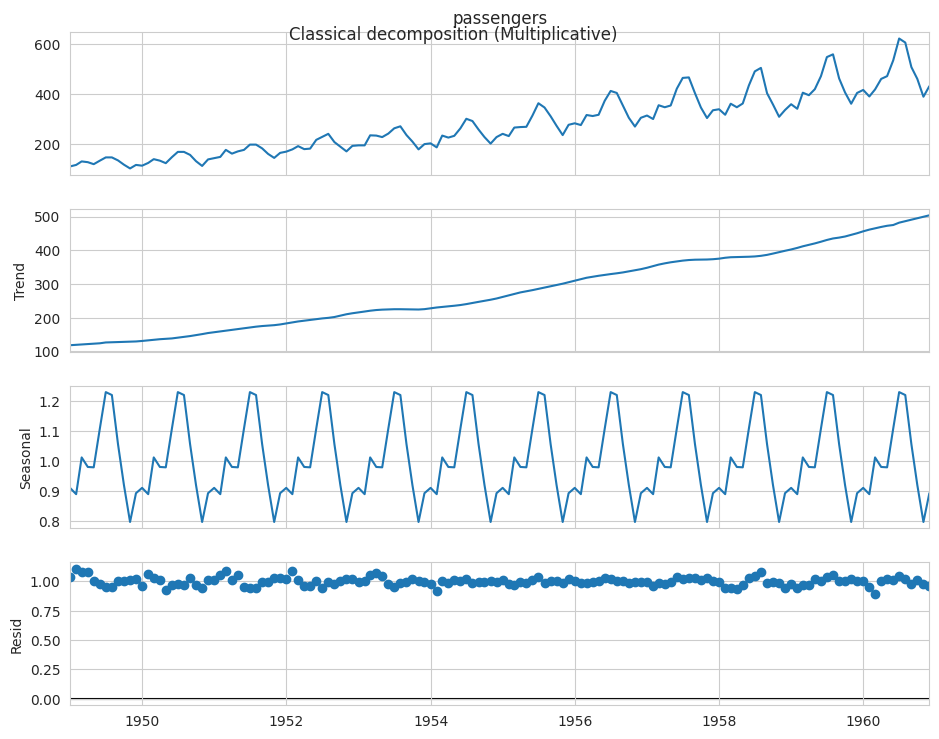

In [ ]:
result = seasonal_decompose(flights['passengers'], model='multiplicative', period=12, extrapolate_trend='freq')


fig = result.plot()
fig.set_size_inches(10,8)
plt.suptitle('Classical decomposition (Multiplicative)', y=0.93)
plt.show()

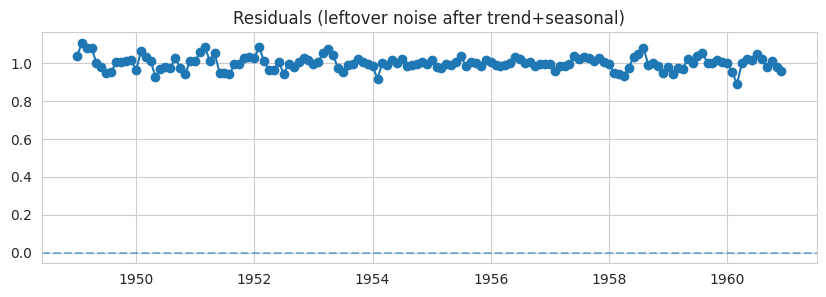

In [ ]:
resid = result.resid
plt.figure(figsize=(10,3))
plt.plot(resid.index, resid.values, marker='o')
plt.axhline(0, linestyle='--', alpha=0.5)
plt.title('Residuals (leftover noise after trend+seasonal)')
plt.show()